In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re
import ipywidgets as widgets
from util.util import get_options_from_file, ewma_halflife
import os
from torch.nn import MSELoss
from skimage.metrics import mean_squared_error
mse = MSELoss()
modelBase = Path('checkpoints')
val_log_file = 'val_loss_log.csv'
models = list(modelBase.rglob(val_log_file))
testResBase = Path('results')
testModels = list(testResBase.glob('*/*'))
testModels = [model for model in testModels if 'npyImages' in os.listdir(model)]

def getPatNameAndImNum(imFileName):
    imFileName = str(imFileName)
    rgx = re.compile('\d{1}_\d{3}|PAT\d{4}_\d{1}')
    patName = rgx.match(imFileName)[0]
    imNum = imFileName.replace(patName, '').replace('fake_B.npy', '').replace('real_B.npy', '').replace('_','')
    return patName, imNum

##  Validation loss over time

In [6]:
# Select model to inspect validation loss
strModels = [str(mdl.parts[-2]) for mdl in models]
selectedModel = widgets.Dropdown(
    options=strModels,
    value=strModels[0],
    description='Model name:',
    disabled=False,
    layout = {'width' : 'initial'}
)
selectedModel

Dropdown(description='Model name:', layout=Layout(width='initial'), options=('npyArray16bitValUnet256Backend',…

In [10]:
optDict = get_options_from_file(modelBase / selectedModel.value / 'train_opt.txt')
trainSize, valSize, testSize = [len(list((path / 'A').glob('*'))) for path in [Path(optDict['dataroot']) / elem for elem in ['train', 'val', 'test']]]

In [11]:
val_log = pd.read_csv(modelBase / selectedModel.value / val_log_file)
val_log.head()
val_log['epochs'] = val_log.iters / trainSize

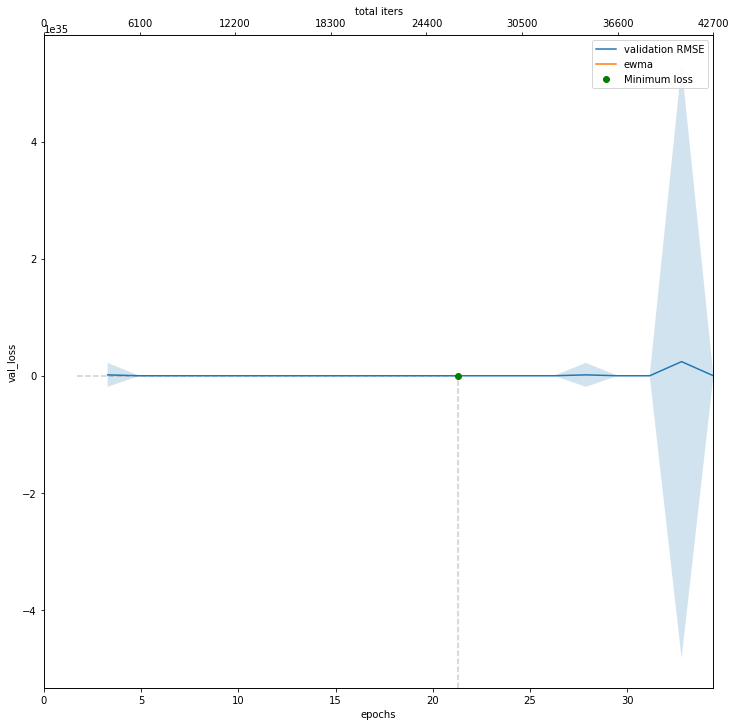

In [12]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
x1, x2 = 'epochs', 'iters'
sns.lineplot(x=x1, y='val_loss', data=val_log, label='validation RMSE', ax = ax1)
plt.fill_between(val_log[x1], val_log.val_loss - val_log.val_std, val_log.val_loss + val_log.val_std, alpha = .2)
halflife = 3
plt.plot(val_log[x1], ewma_halflife(val_log.val_loss, halflife), label = 'ewma')

min_row = val_log.sort_values('val_loss', ascending=True).iloc[[0], :]
# sns.scatterplot(min_row.epochs, min_row.val_loss, ax=ax1)
plt.plot(min_row.epochs, min_row.val_loss, 'go', label = 'Minimum loss')

plt.legend()
xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
plt.vlines(min_row.epochs.values[0], ylim[0], min_row.val_loss.values[0], linestyles = 'dashed', alpha = .2)
plt.hlines(min_row.val_loss.values[0], xlim[0], min_row.epochs.values[0], linestyles = 'dashed', alpha = .2)
plt.xlim((0, np.max(val_log[x1])))
plt.ylim(ylim)

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(ax1.get_xticks()*trainSize)
ax2.set_xlabel('total iters');



## Test set RMSE loss

In [188]:
selectedTestModels = widgets.SelectMultiple(
    options=testModels,
    rows=20,
    description='Models',
    disabled=False,
    layout = {'width' : 'initial'}
)
selectedTestModels

SelectMultiple(description='Models', layout=Layout(width='initial'), options=(PosixPath('results/npyArray16bit…

In [189]:
row_list = []
for model in selectedTestModels.value:
    print(model)
    fake_B_images = list(model.glob('npyImages/*fake_B.npy'))
    real_B_images = list(model.glob('npyImages/*real_B.npy'))
    fake_B_images.sort()
    real_B_images.sort()
    # real and fake images should be corresponding now
    for fake_im, real_im in zip(fake_B_images, real_B_images):
        patName, imageNumber = getPatNameAndImNum(fake_im.name)
        real_im_npy = np.load(real_im)[0]
        fake_im_npy = np.load(fake_im)[0]
        error_im = real_im_npy - fake_im_npy

        row_list.append(
            {
                'Model' : str(model.parts[1]),
                'epoch' : str(model.parts[2]).replace('test_', ''),
                'Patient' : patName,
                'ImageNumber' : imageNumber,
                'RMSE' : np.sqrt(np.mean(error_im)**2 + np.std(error_im)**2),
                # 'skimage_RMSE' : np.sqrt(mean_squared_error(real_im_npy, fake_im_npy))
            }
        )

results/npyArray16bitValUnet256Backend/test_60
results/npyArray16bitValUnet256Backend/test_15
results/npyArray16bitValUnet256Backend/test_25
results/npyArray16bitValUnet256Backend/test_50
results/npyArray16bitValUnet256Backend/test_20
results/npyArray16bitValUnet256Backend/test_10
results/npyArray16bitValUnet256Backend/test_30
results/npyArray16bitValUnet256Backend/test_40


In [206]:
df = pd.DataFrame(row_list)
df.Patient = df.Patient.astype('category')
df

,Model,epoch,Patient,ImageNumber,RMSE
0,npyArray16bitValUnet256Backend,60,2_010,000,0.071838
1,npyArray16bitValUnet256Backend,60,2_010,001,0.069973
2,npyArray16bitValUnet256Backend,60,2_010,002,0.065167
3,npyArray16bitValUnet256Backend,60,2_010,003,0.061454
4,npyArray16bitValUnet256Backend,60,2_010,004,0.057911
...,...,...,...,...,...
3683,npyArray16bitValUnet256Backend,40,3_053,178,0.058633
3684,npyArray16bitValUnet256Backend,40,3_053,179,0.060408
3685,npyArray16bitValUnet256Backend,40,3_053,180,0.060720
3686,npyArray16bitValUnet256Backend,40,3_053,181,0.058393


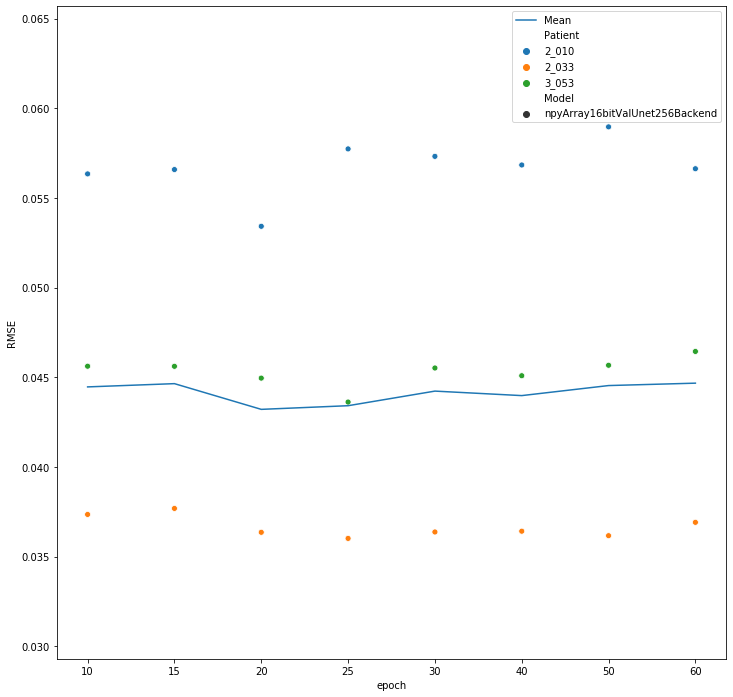

In [219]:
plt.figure(figsize = (12,12))
sns.scatterplot(data = df.groupby(['Patient', 'epoch' , 'Model']).mean().reset_index(), x = 'epoch', y = 'RMSE', hue = 'Patient', style = 'Model')
sns.lineplot(data = df.groupby(['epoch']).mean().reset_index(), x = 'epoch', y = 'RMSE', label = 'Mean')


In [225]:
df.groupby(['epoch']).mean()

,RMSE
epoch,
10,0.044464
15,0.044645
20,0.043211
25,0.043415
30,0.044229
40,0.043978
50,0.044538
60,0.044672


In [196]:
pd.DataFrame(row_list).groupby(['Patient', 'epoch']).mean().reset_index()

,Patient,epoch,RMSE
0,2_010,10,0.056339
1,2_010,15,0.056582
2,2_010,20,0.053418
3,2_010,25,0.057733
4,2_010,30,0.057317
5,2_010,40,0.056836
6,2_010,50,0.058962
7,2_010,60,0.056628
8,2_033,10,0.037353
9,2_033,15,0.037688


In [87]:
test_im_fake = np.load(fake_B_images[0]).astype(np.float32)
test_im_real  = np.load(real_B_images[0]).astype(np.float32)

(-0.5, 255.5, 255.5, -0.5)

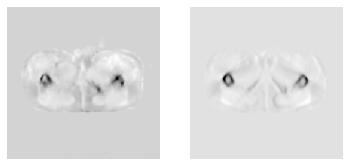

In [88]:
plt.subplot(121)
plt.imshow(test_im_fake[0], cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_im_real[0], cmap ='gray')
plt.axis('off')

In [114]:
testStrs = ['2_011_7_fake_B.npy' , 'PAT1056_1_100_fake_B.npy']

[rgx.match(elem)[0] for elem in testStrs]

['2_011', 'PAT1056_1']

In [115]:
getPatNameAndImNum(testStrs[1])

('PAT1056_1', '100')